# Hyperparameters & Model Validation

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data
y = iris.target

In [4]:
from sklearn.model_selection import train_test_split

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# the label of an unknown point is the same as the label of its closest training point
model = KNeighborsClassifier(n_neighbors=1)  

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)

accuracy_score(y2, y2_model)

0.9066666666666666

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the above case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use **cross-validation**; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)

accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of cross-validation is a two-fold cross-validation—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation.

We split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's `cross_val_score` convenience routine to do it succinctly:

In [7]:
from sklearn.model_selection import cross_val_score  # Import cross_val_score from model_selection

cross_val_score(model, X, y, cv=5)  # Perform cross-validation with 5 folds

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the `cross_validation` module. For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial. This type of cross-validation is known as leave-one-out cross validation, and can be used as follows:

In [8]:
# Import LeaveOneOut and cross_val_score from model_selection
from sklearn.model_selection import LeaveOneOut, cross_val_score  

loo = LeaveOneOut()                            # Initialize LeaveOneOut cross-validator
scores = cross_val_score(model, X, y, cv=loo)  # Perform Leave-One-Out cross-validation
scores                                         # Display the scores for each iteration

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction. Taking the mean of these gives an estimate of the error rate:

In [9]:
scores.mean()

0.96

# Selecting the Best Model
Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters. These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: if our estimator is underperforming, how should we move forward? There are several possible answers:

* Use a more complicated/more flexible model
* Use a less complicated/less flexible model
* Gather more training samples
* Gather more data to add features to each sample

The answer to this question is often counter-intuitive. In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results! The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off
Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between bias and variance. Consider the following figure, which presents two regression fits to the same dataset:

<center>
    <img src="images/05.03-bias-variance.png" width="1000" />
</center>

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data. Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well. Such a model is said to underfit the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high bias.

The model on the right attempts to fit a high-order polynomial through the data. Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to overfit the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high variance.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data. In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

<center>
    <img src="images/05.03-bias-variance-2.png" width="1000" />
</center>

The score here is the **R^2** score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. `R^2 = 1` indicates a perfect match, `R^2 = 0` indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models. From the scores associated with these two models, we can make an observation that holds more generally:

* For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
* For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

<left>
    <img src="images/05.03-validation-curve.png" width="600" />
</left>

The diagram shown here is often called a *validation curve*, and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

In [11]:
def make_data(N, err=1.0, rseed=1):
    
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
        
    return X, y

X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees:

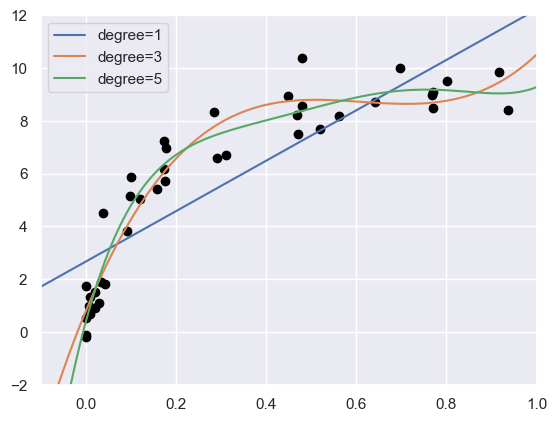

In [12]:
# Create a test dataset with 500 points ranging from -0.1 to 1.1, reshaped to be a column vector
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

# Plot the original data points (X, y) as a scatter plot in black
plt.scatter(X.ravel(), y, color='black')

# Capture the current axis limits (xmin, xmax, ymin, ymax) - though not used later
axis = plt.axis()

# Loop through polynomial degrees 1, 3, and 5
for degree in [1, 3, 5]:
    
    # Fit a Polynomial Regression model with the current degree, predict the output for X_test
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    
    # Plot the predicted values y_test against X_test, label with the degree of the polynomial
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
    
# Set the x-axis limits of the plot from -0.1 to 1.0
plt.xlim(-0.1, 1.0)

# Set the y-axis limits of the plot from -2 to 12
plt.ylim(-2, 12)

# Add a legend to the plot, positioning it in the best location
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer. A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the `validation_curve` convenience routine provided by Scikit-Learn. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

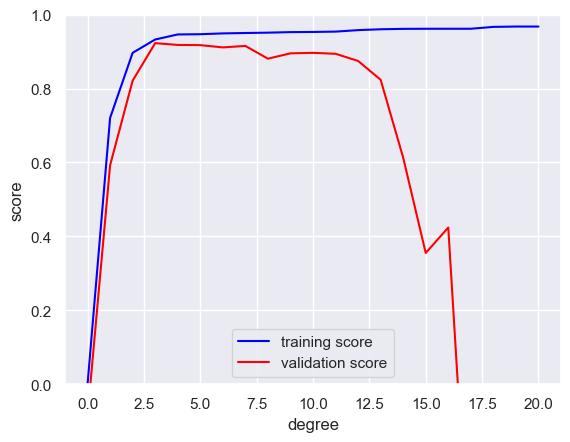

In [13]:
# Import validation_curve from the correct module
from sklearn.model_selection import validation_curve

# Create an array of polynomial degrees from 0 to 20
degree = np.arange(0, 21)

# Calculate the training and validation scores for Polynomial Regression models of varying degrees
train_score, val_score = validation_curve(
    PolynomialRegression(), X, y,
    param_name='polynomialfeatures__degree', param_range=degree, cv=7
)

# Plot the median training scores for each polynomial degree in blue
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')

# Plot the median validation scores for each polynomial degree in red
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')

# Add a legend to the plot
plt.legend(loc='best')

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Label the x-axis as 'degree'
plt.xlabel('degree')

# Label the y-axis as 'score'
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

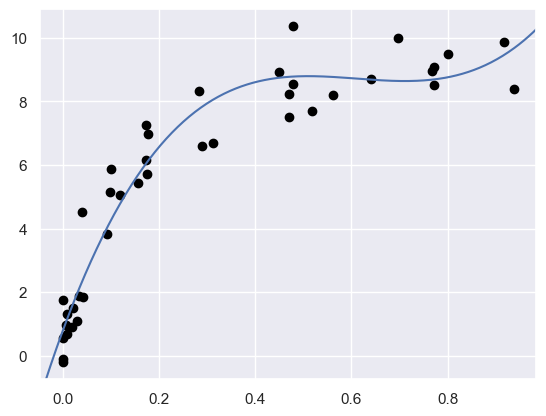

In [14]:
# Plot the original data points (features X and target y) as a scatter plot
plt.scatter(X.ravel(), y, color='black')

# Save the current axis limits to maintain consistent axis scaling
lim = plt.axis()

# Fit a polynomial regression model of degree 3 to the data (X, y)
# and predict the output for the test data (X_test)
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)

# Plot the predictions of the polynomial regression model
plt.plot(X_test.ravel(), y_test);

# Set the axis limits to the previously saved limits to ensure consistent scaling
plt.axis(lim);   # Not putting ';' makes the parameters appear before the graphic.

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

# Learning Curves
One important aspect of model complexity is that the optimal model will generally depend on the size of your training data. For example, let's generate a new dataset with a factor of five more points:

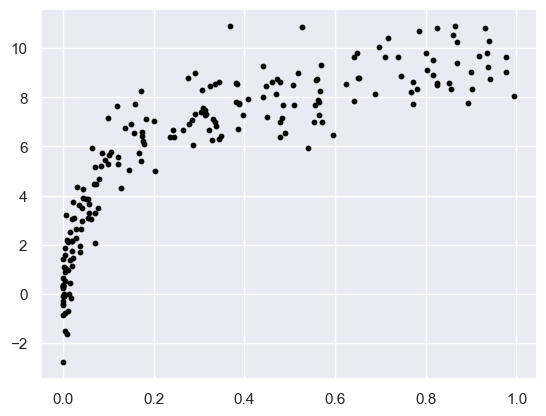

In [15]:
# Generates a dataset with 200 samples
X2, y2 = make_data(200)

# Plots these data points
plt.scatter(X2.ravel(), y2, s=10, color='black');    # X2.ravel() flattens the array X2 to a 1-dimensional array

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

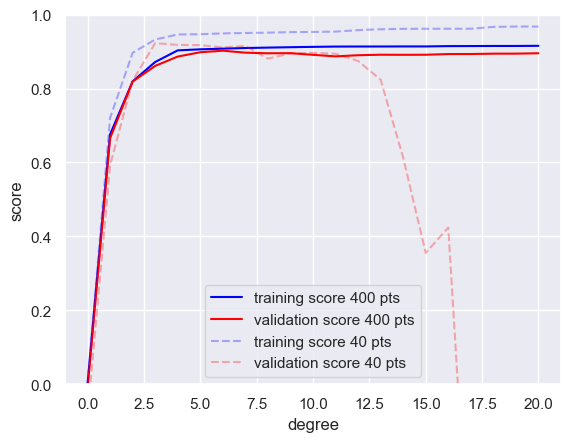

In [16]:
# Import validation_curve from the correct module
# from sklearn.model_selection import validation_curve

# Create an array of polynomial degrees from 0 to 20
degree = np.arange(0, 21)

# Calculate the training and validation scores for Polynomial Regression models of varying degrees (400 points)
train_score2, val_score2 = validation_curve(
    PolynomialRegression(), X2, y2,
    param_name='polynomialfeatures__degree', param_range=degree, cv=7
)

# Plot the median training scores for each polynomial degree in blue
plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score 400 pts')       # 400 points

# Plot the median validation scores for each polynomial degree in red
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score 400 pts')        # 400 points

# Plot the median training scores for each polynomial degree in blue
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed', label='training score 40 pts')   # 40 points

# Plot the median validation scores for each polynomial degree in red
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed', label='validation score 40 pts')    # 40 points

# Add a legend to the plot
plt.legend(loc='lower center')

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Label the x-axis as 'degree'
plt.xlabel('degree')

# Label the y-axis as 'score'
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset. It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points. It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model. A plot of the training/validation score with respect to the size of the training set is known as a learning curve.

The general behavior we would expect from a learning curve is this:

* A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
* A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.
* A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

<left>
    <img src="images/05.03-learning-curve.png" width="600" />
</left>

The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows. In particular, once you have enough points that a particular model has converged, adding more training data will not help you! The only way to increase model performance in this case is to use another (often more complex) model.

### Learning curves in Scikit-Learn
Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

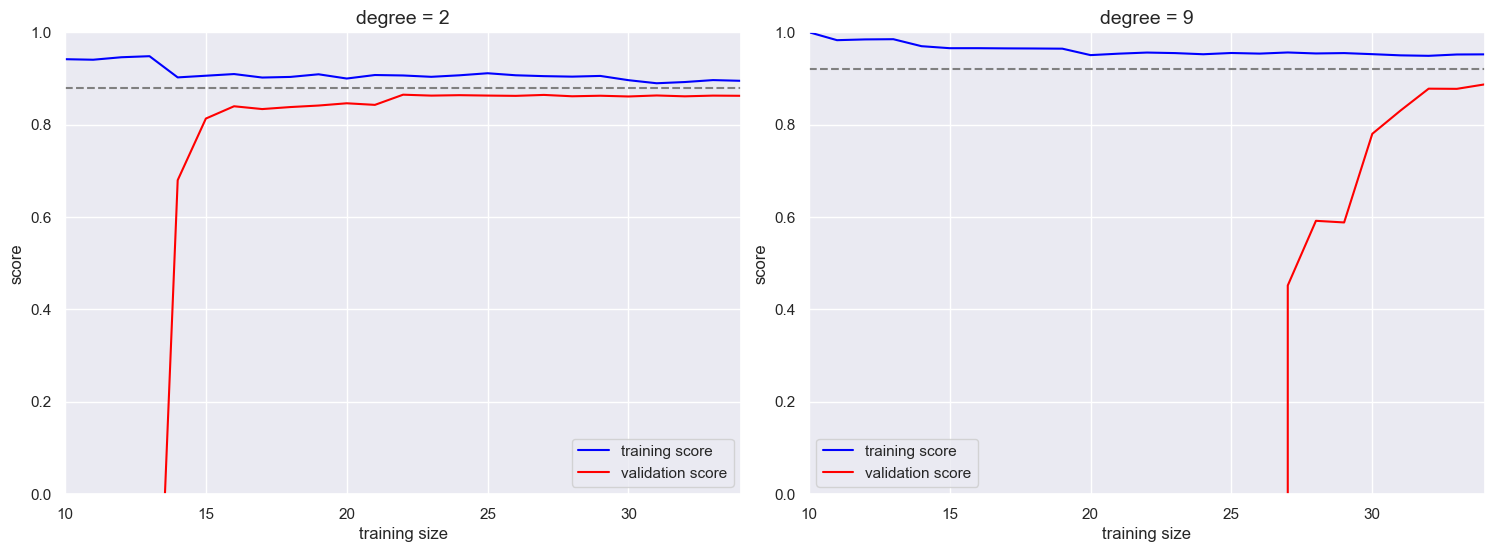

In [17]:
# Import the learning_curve function from sklearn.model_selection
from sklearn.model_selection import learning_curve

# Create a figure with 1 row and 2 columns of subplots, with specified figure size
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Adjust the layout of the subplots
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# Loop through the specified polynomial degrees
for i, degree in enumerate([2, 9]):
    
    # Compute the learning curves for the given polynomial degree
    N, train_lc, val_lc = learning_curve(
        PolynomialRegression(degree),
        X, y,
        cv=7,  # Number of cross-validation folds
        train_sizes=np.linspace(0.3, 1, 25)  # Array of training sizes
    )

    # Plot the mean training scores against the training sizes
    ax[i].plot(N, np.mean(train_lc, axis=1), color='blue', label='training score')
    
    # Plot the mean validation scores against the training sizes
    ax[i].plot(N, np.mean(val_lc, axis=1), color='red', label='validation score')
    
    # Add a horizontal dashed line at the mean of the final training and validation scores
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')
    
    ax[i].set_ylim(0, 1)               # Set the y-axis limits from 0 to 1   
    ax[i].set_xlim(N[0], N[-1])        # Set the x-axis limits to cover the range of training sizes
    ax[i].set_xlabel('training size')  # Label the x-axis as 'training size'
    ax[i].set_ylabel('score')          # Label the y-axis as 'score'
    ax[i].set_title('degree = {0}'.format(degree), size=14)  # Set the title of the subplot to indicate the polynomial degree
    ax[i].legend(loc='best')                                 # Add a legend to the subplot

plt.show() # Display the plot

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

## Validation in Practice: Grid Search

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define a pipeline that includes polynomial features, normalization, and linear regression
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linearregression', LinearRegression())
])

# Define the parameter grid for grid search
param_grid = {
    'polynomialfeatures__degree': np.arange(21),  # Range of degrees for polynomial features
    'linearregression__fit_intercept': [True, False]  # Whether to fit the intercept
}

# Create a GridSearchCV object with the pipeline and the parameter grid
grid = GridSearchCV(pipeline, param_grid, cv=7)

# Fit the grid search to the data
grid.fit(X, y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

Now that this is fit, we can ask for the best parameters as follows:

In [19]:
grid.best_params_

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 4}

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

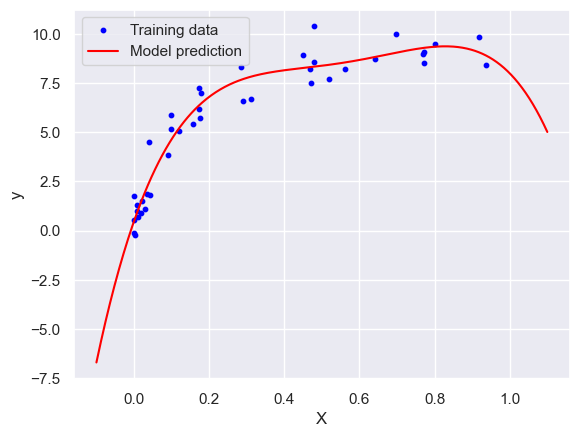

In [20]:
# Get the best estimator from grid search
model = grid.best_estimator_

# Fit the model to the entire training data
model.fit(X, y)

# Predict on the test data
y_test = model.predict(X_test)

# Plot training data
plt.scatter(X.ravel(), y, s=10, color='blue', label='Training data')

# Plot the model predictions
plt.plot(X_test.ravel(), y_test, color='red', label='Model prediction')

# Maintain axis limits
lim = plt.axis()
plt.axis(lim)

# Add labels and legend
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.

# Feature Engineering

One common type of non-numerical data is categorical data. For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information. For example, your data might look something like this:

In [21]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [22]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities. Thus such a mapping would imply, for example, that Queen Anne < Fremont < Wallingford, or even that Wallingford - Queen Anne = Fremont, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use one-hot encoding, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively. When your data comes as a list of dictionaries, Scikit-Learn's `DictVectorizer` will do this for you:

In [23]:
from sklearn.feature_extraction import DictVectorizer


# Create an instance of DictVectorizer
vec = DictVectorizer(sparse=False, # `sparse=False` ensures the output is a dense array rather than a sparse matrix
                     dtype=int)    # `dtype=int` specifies the type of the output values

# Fit the vectorizer to the data and transform the data
transformed_data = vec.fit_transform(data)

transformed_data

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood. With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [24]:
# Get the feature names from the vectorizer
feature_names = vec.get_feature_names_out()

feature_names

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

There is one clear disadvantage of this approach: if your category has many possible values, this can greatly increase the size of your dataset. However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [25]:
vec = DictVectorizer(sparse=True, dtype=int)

vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models.

### Text Features
Another common need in feature engineering is to convert text to a set of representative numerical values. For example, most automatic mining of social media data relies on some form of encoding the text as numbers. One of the simplest methods of encoding data is by word counts: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [26]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on. While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's `CountVectorizer`:

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()

X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [28]:
print(X)

  (0, 3)	1
  (0, 2)	1
  (0, 0)	1
  (1, 0)	1
  (1, 4)	1
  (2, 3)	1
  (2, 1)	1


The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a DataFrame with labeled columns:

#### Remember:

```Python
sample = ['problem of evil',
          'evil queen',
          'horizon problem']
```

In [29]:
# Create DataFrame with feature names
df = pd.DataFrame(X.toarray(),                           # Converts a sparse matrix X into a dense NumPy array.
                  columns=vec.get_feature_names_out())   # Provides the names of the features

# Display the DataFrame
df

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms. One approach to fix this is known as term *frequency-inverse document frequency (TF–IDF)* which weights the word counts by a measure of how often they appear in the documents. The syntax for computing these features is similar to the previous example:

<center>
    <img src="images/tfidf.png" width="600" />
</center>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create and fit the TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)

# Create a DataFrame with the dense array and feature names
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
df

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


### Derived Features

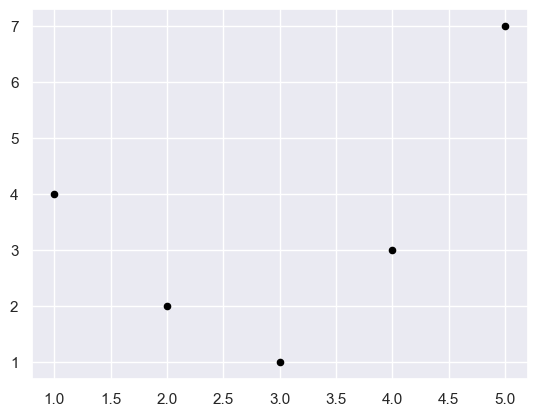

In [31]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])

plt.scatter(x, y, s=20, color='black');

Still, we can fit a line to the data using LinearRegression and get the optimal result:

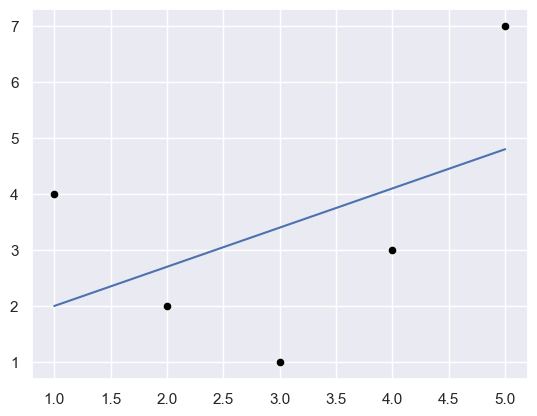

In [32]:
from sklearn.linear_model import LinearRegression

# Reshape the 1D array 'x' into a 2D column vector by adding a new axis.
X = x[:, np.newaxis]  # The ':' selects all elements along the current dimension, and 'np.newaxis' adds a new axis.

# Fit a linear regression model to the reshaped data 'X' and target values 'y'.
model = LinearRegression().fit(X, y)

# Predict target values using the fitted model and the reshaped data 'X'.
yfit = model.predict(X)

# Create a scatter plot of the original data points (x, y).
plt.scatter(x, y, s=20, color='black')

# Plot the predicted values 'yfit' as a line, based on the original x values.
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between x and y.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model. For example, we can add polynomial features to the data this way:

In [33]:
from sklearn.preprocessing import PolynomialFeatures

# Create a PolynomialFeatures transformer with degree 3.
poly = PolynomialFeatures(degree=3, include_bias=False)          # 'include_bias=False' means we do not want to include the bias (intercept) 
                                                                 # term in the output.

# Transform the input data 'X' to include polynomial features up to the specified degree.
X2 = poly.fit_transform(X)

# Print the transformed feature matrix 'X2' to see the polynomial features.
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column representing **x**, and a second column representing **x^2**, and a third column representing **x^3**. 

Computing a linear regression on this expanded input gives a much closer fit to our data:

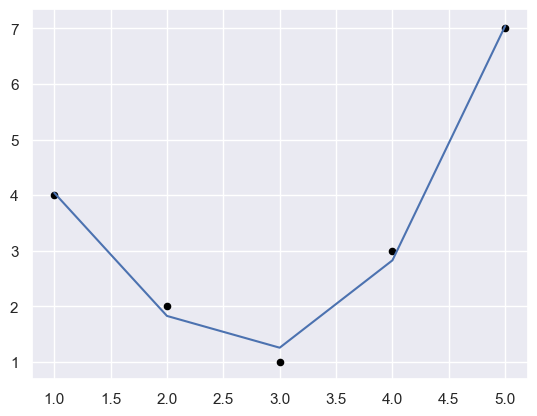

In [34]:
# Create a LinearRegression model and fit it to the transformed feature matrix 'X2' and target variable 'y'.
# The model will learn the best-fitting line based on the polynomial features of 'X2'.
model = LinearRegression().fit(X2, y)

# Use the fitted model to predict values based on the transformed feature matrix 'X2'.
# These predictions will fit the polynomial curve learned by the model.
yfit = model.predict(X2)

# Plot the original data points as a scatter plot with black color and size 20.
plt.scatter(x, y, s=20, color='black')

# Plot the polynomial regression curve obtained from the model's predictions.
# The 'x' values are used for plotting the curve, and 'yfit' contains the corresponding predicted values.
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.

# Imputation of Missing Data

In [35]:
from numpy import nan

X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])

y = np.array([14, 16, -1,  8, -5])

print(X)
print()
print(y)

[[nan  0.  3.]
 [ 3.  7.  9.]
 [ 3.  5.  2.]
 [ 4. nan  6.]
 [ 8.  8.  1.]]

[14 16 -1  8 -5]


In [36]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object that replaces missing values with the mean of each column.
imp = SimpleImputer(strategy='mean')

# Fit the imputer on the data 'X' and transform it to replace missing values.
X3 = imp.fit_transform(X)

# Print the transformed data with missing values replaced.
X3

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a LinearRegression estimator:

In [37]:
# Create and fit a Linear Regression model using the transformed data 'X2' and target variable 'y'.
model3 = LinearRegression().fit(X3, y)

# Use the fitted model to make predictions on the transformed data 'X2'.
model.predict(X3)

array([ -9.27857143,  -0.88571429,  -2.11190476,  -5.54047619,
       -20.04047619])

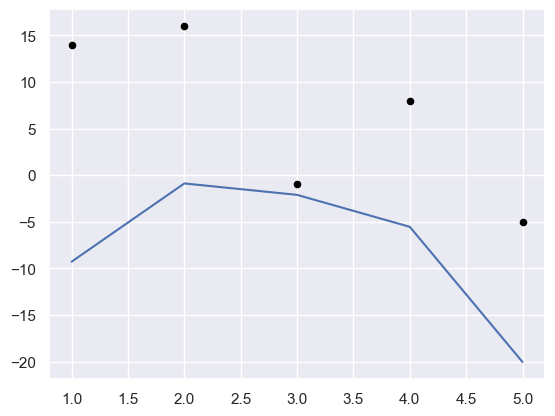

In [38]:
# Use the fitted model to predict values based on the transformed feature matrix 'X2'.
# These predictions will fit the polynomial curve learned by the model.
yfit = model.predict(X3)

# Plot the original data points as a scatter plot with black color and size 20.
plt.scatter(x, y, s=20, color='black')

# Plot the polynomial regression curve obtained from the model's predictions.
# The 'x' values are used for plotting the curve, and 'yfit' contains the corresponding predicted values.
plt.plot(x, yfit);

# Feature Pipelines

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps. For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression
   
To streamline this type of processing pipeline, Scikit-Learn provides a `Pipeline` object, which can be used as follows:

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer               # Import SimpleImputer for handling missing values
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create a pipeline that performs imputation, polynomial feature generation, and linear regression
model = make_pipeline(SimpleImputer(strategy='mean'),  # Impute missing values using the mean strategy
                      PolynomialFeatures(degree=2),    # Generate polynomial features of degree 2
                      LinearRegression())              # Apply linear regression

This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [40]:
X

array([[nan,  0.,  3.],
       [ 3.,  7.,  9.],
       [ 3.,  5.,  2.],
       [ 4., nan,  6.],
       [ 8.,  8.,  1.]])

In [41]:
# Train the pipeline model using the data X (which contain missing values) and target variable y
model.fit(X, y) 

# Print the true target values y
print(y)   

# Predict the target values using the trained model and the input data X 
# (including any missing values that will be imputed by the SimpleImputer in the pipeline)
print(model.predict(X)) 

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


All the steps of the model are applied automatically. Notice that for the simplicity of this demonstration, we've applied the model to the data it was trained on; this is why it was able to perfectly predict the result.